* Data == (General trend +/* Seasonality +/* Cyclical movements +/* Unexpected variations : Unexpected variations are stochastic and cannot be framed in a mathematical model for a definitive future prediction. This type of error is due to lack of information about explanatory variables that can model these variations or due to presence of a random noise.)

* Unlike general time series data where we can look for seasonality and Cyclical movements for accurate modeling...here it is error prone .... .. 

# Data generation by capturing the 'trend' and varying the 'noise' :


* ### Our data can be seen as TREND + NOISE 
* ### Ideally we want to vary the 'noise' without effecting the underlying 'trend'
* ### But,theoritically what is 'trend' and 'noise'
* ### Any data/information that does not have predictive power is noise.So what constitutes as 'noise' depends on what we are trying to predict.(like milli sec price variations constitute as noise if we are trading at hourly/daily.)So for iterative methods like 'deep learning' each time we pass the data we can show different versions of data in each keeping the trend same but varying degree /and distribution of noise.

* ### Say ,We used some machine learning model to fit the data and then add noise on top of it(this includes unsupervised/semisupervised models too) to model the data generation process and used that data for training an RL algorithm..we are in essence feeding the information captured by a less powerful/predictive model which is plain stupid.If we are using a complex(more representative) data generation process like conditional GAN'S we lose interpretability.


* ### To split a give data into TREND + NOISE we need to formulate it as machine learning problem....say we split the data into train,valid,test and get the best model(one that hopefully captured the 'trend') but the whole point is all the conventional models don't fare well in capturing this 'trend'.

* ### But,to fit the data we don't need complex models...it's important to understand that a model that has enough capacity to perfectly fit the data might not be complex enough to model the structure of data(generalizability).





## key idea:

### Since we realized how explicitly trying to model the 'trend' and thereby 'noise' is not the way to go for data generation.

* so we can choose slightly different ways to fit the curves each modeling the noise differently implicitly.
* We can make different models that are simple enough but can almost fit the data(note: we are not doing machine learning here...no learning..aka generalization happening here).This way we can ensure that our slightly different versions of the data will force our RL algorithm to learn the invariant structure.

* In fact this process is routinely done in Computer Vision to make the model robust.But,identifying invariant transformations(like centercrop,horizontalflip,randomjitter...) is easier there as we can perceive the data easily which is not the case here.


In [10]:

# Function for Sigle exponential smoothing
# def single_exp_smoothing(x, alpha):
#     F = [x[0]] # first value is same as series
#     for t in range(1, len(x)):
#         F.append(alpha * x[t] + (1 - alpha) * F[t-1])
#     return F

# NOTE: THE ABOVE FUNCTION....WILL NOT WORK FOR OBVIOUS REASONS..

# Here our model assumes that all values are result of some trend + first_order approxi
# let's say: X(t+1) = F(t) + T(t)
# F(t+1) = alpha*x(t) + (1-alpha)*(F(t-1))
#T(t+1) = beta*(F(t) - F(t-1)) + (1-beta)*T(t-1)
# intital value of trend is captured by x(1)  - x(0)
def double_exp_smoothing(x, alpha=0.8, beta=0.5):#here we are choosing higher alpha to have a better fit...note all
# methods can be seen as adding different types of noise but implicitly through curve fitting.
    yhat = [x.iloc[0]] # first value is same as series
    for t in range(1, len(x)):
        if t==1:
            F, T= x[0], x[1] - x[0]
        F_n_1, F = F, alpha*x[t] + (1-alpha)*(F+T)
        T=beta*(F-F_n_1)+(1-beta)*T
        yhat.append(F+T)
    return pd.Series(yhat,index = x.index)



def goodness_fit(fit,orginal):
    return (fit-orginal).sum()/len(fit)

In [3]:
import pandas as pd
data = pd.read_csv('data.csv',index_col = ['DateTime'],infer_datetime_format=True,parse_dates=['DateTime'])

In [4]:
data.head(2)

,BANKBARODA_0,BANKBARODA_1,BANKBARODA_2,BANKBARODA_3,BANKBARODA_4,CANARABANK_0,CANARABANK_1,CANARABANK_2,CANARABANK_3,CANARABANK_4,...,SBI_0,SBI_1,SBI_2,SBI_3,SBI_4,PNB_0,PNB_1,PNB_2,PNB_3,PNB_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-04-01 11:06:00,148.9,148.9,148.9,148.9,3500,262.90,262.90,262.85,262.85,9000,...,245.05,245.2,245.05,245.10,36000,8208.0,8208.9,8206.90,8207.05,8625
2017-04-01 11:07:00,148.8,148.9,148.8,148.9,7000,262.75,262.75,262.75,262.75,3000,...,245.10,245.1,245.05,245.05,27000,8207.1,8208.0,8205.95,8206.15,8850


In [19]:
new_data  = data.copy()

In [37]:
def gen_data(df,base,*rest):
    df[base] = double_exp_smoothing(df[base])
    errors = data[base]-df[base]
    for col in rest:
        df[col] = data[col] + errors
        
def goodness_fit(fit,orginal):
    return (fit-orginal).sum()/len(fit)        
    

In [23]:
gen_data(new_data,'BANKBARODA_2','BANKBARODA_0', 'BANKBARODA_1','BANKBARODA_3')



In [27]:
gen_data(new_data,'CANARABANK_2','CANARABANK_0','CANARABANK_1','CANARABANK_3')

In [29]:
gen_data(new_data,'SBI_2','SBI_0', 'SBI_1','SBI_3')


In [30]:
gen_data(new_data,'PNB_2','PNB_0', 'PNB_1','PNB_3')

In [14]:
new_data.head(2)

,BANKBARODA_0,BANKBARODA_1,BANKBARODA_2,BANKBARODA_3,BANKBARODA_4,CANARABANK_0,CANARABANK_1,CANARABANK_2,CANARABANK_3,CANARABANK_4,...,SBI_0,SBI_1,SBI_2,SBI_3,SBI_4,PNB_0,PNB_1,PNB_2,PNB_3,PNB_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-04-01 11:06:00,148.9,148.9,148.9,148.9,3500,262.9,262.9,262.85,262.85,9000,...,245.05,245.2,245.05,245.1,36000,8208.0,8208.9,8206.9,8207.05,8625
2017-04-01 11:07:00,148.7,148.9,148.7,148.9,7000,262.6,262.6,262.65,262.65,3000,...,245.15,245.0,245.05,245.0,27000,8206.2,8207.1,8205.0,8205.25,8850


# let's see how the data looks..

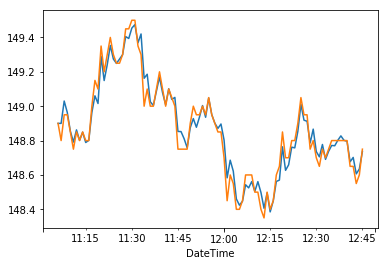

In [34]:
new_data['BANKBARODA_0'].iloc[:100].plot()
data['BANKBARODA_0'].iloc[:100].plot()

# let's see how we have modeled 'noise'

In [35]:
import numpy as np
from scipy import stats
error = new_data['BANKBARODA_0'].iloc[:1000] - data['BANKBARODA_0'].iloc[:1000]
print('mean=', np.mean(error))
print('std=',np.std(error))
print('skewness=',stats.skew(error))
print('kurtosis=',stats.kurtosis(error))

mean= -0.003966119067278811
std= 0.056729333105125616
skewness= -1.0704254536462319
kurtosis= 5.985661096807817


/home/vinay/anaconda3/envs/datascience/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


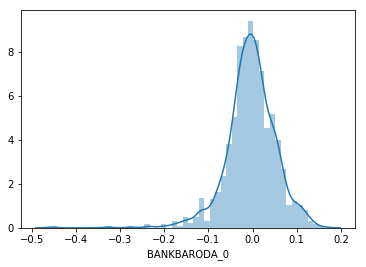

In [36]:
# THAT SHOWS WE HAVE LEFT SKEWNESS ... OTHERWISE PRETTY NORMAL DIST ... LET'S PLOT IT AND CONFIRM..

import seaborn as sns
sns.distplot(error) # Note only look at the shape not the 'y' values..they are scaled...

# So,what we have done ?
* Instead of creating/adding gaussian noise naively we are modeling noise based on a model.How and when(training/testing..) we can use this data depends on the algorithm we are using..(value,policy or hybrid..)....

In [ ]:
# NOTE: ABOVE METHOD IS NOT THE ONLY WAY ... BUT WILL PARK IT ASIDE FOR A WHILE..

In [38]:
# sanity check....
goodness_fit(new_data['BANKBARODA_0'],data['BANKBARODA_0'])

5.945212391034271e-05

In [39]:
new_data.to_csv('new_data.csv')

# ref :  Since our fundamental concern is limited data and making our model robust...i'm considering orthogonal approaches....along the directions of this paper...

[MBVE: Augmenting real experiences with fictitious ones](https://arxiv.org/pdf/1803.00101.pdf)



## OBVIOUSLY..A LOT OF OTHER APPROACHES ARE TRIED...I WOULD LATER DOCUMENT THEM MORE THOROUGHLY AS I FEEL THE PROCESS  IS STILL ONGOING BUT HERE ARE SOME OF THEM...

## Since the whole idea is to explicitly model the data generation process and fitting the model on data as closely as possible .....for eg: say we know our data lies on a hyperplane but corrupted with some noise ...most sensible approach would be to formulate a regression problem and the error bars would correspond as 'noise' ...similarly in our case we should come up with an explicit model here are some others that have been tried/thought but abandoned:

### General Note : Unfortunately, the presence of trend and seasonal variation can be hard to estimate and/or remove. The chief difficultly is that the underlying dynamics generating the data are unknown. Volumes have been written on how to “guesstimate” it, with little overall agreement on the optimal method.It is often very difficult to define trend and seasonality satisfactorily. Moreover, even if you can correctly identify the trend it is important to ensure the right sort of trend (global or local) is modeled. This is important because traditional statistical approaches require the specification of an assumed time-series model, such as auto-regressive models, Linear Dynamical Systems, or Hidden Markov Model.

* Get a 'n' rolling window and formulate crazy functions
* Similar to double_exponential..we can also try to model for cycles/seasonality by adding another variable...
* Kalman filters
* Fancy MA + AR....AKA arma methods
* Can also make non-linear auto regressive models...